# Description
Notebook to run simulations for Referee comment 4.2, on using the Meteoric Seed Set instead of our seed set during expansion

### Load packages

In [1]:
import networkExpansionPy.lib as ne
import numpy as np
import pandas as pd
import pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests
plt.rcParams['font.family'] = 'Arial'

#import warnings
#from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
#    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
#warnings.simplefilter('ignore',SparseEfficiencyWarning)

def load_data(network_name):
    with open(ne.asset_path  + "/metabolic_networks/" + network_name,"rb") as filehandler:
        metabolism = pickle.load(filehandler)
    return metabolism

# load the metabolism object from the repo
#metabolism = load_data('metabolism.23Aug2022.pkl')
#model_id = "metabolism.v4.20Mar2023.pkl"
#model_id = "metabolism.v5.12Apr2023.pkl"
model_id = "metabolism.v8.01May2023.pkl"

metabolism = pd.read_pickle('/Users/joshuagoldford/Documents/github/network-expansion-assets/models/' + model_id)
cids = metabolism.coenzymes

In [2]:
compounds = pd.read_csv("../assets/Prebiotic Compounds - Murchison.csv")
compounds = [x.strip("\t") for x in compounds["KEGG Compound"].unique().tolist() if "-" != x]
seed = pd.read_csv('../assets/seed_set.csv')
background = seed[seed["Type"].isin(["Background"])].ID.tolist()

### Run network expansion

In [3]:
#seed_set = pd.read_csv('assets/seed_set.csv')['ID'].tolist()
seed_set = compounds + background


#seed_df = pd.read_csv('assets/seed_set.csv')
#seed_set = seed_df[~seed_df.Type.isin(["Organic carbon"])].ID.tolist()
#seed_set = seed_set + ["C00010"]

print('There were {N} compounds in this seed set...'.format(N=len(seed_set)))

ne_cpds,ne_rxns = metabolism.expand(seed_set,algorithm='trace')
print('There were {N} compounds produced in this expansion!'.format(N=len(ne_cpds)))

# parse data into dataframes
rn_df = pd.DataFrame(pd.Series(ne_rxns),columns = ['iteration'])
rn_df.reset_index(inplace=True)
rn_df.columns = ['rn','direction','iteration']
rn_df['rn_kegg']= rn_df['rn'].apply(lambda x: x.split('_')[0])


There were 99 compounds in this seed set...


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:536: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  X,Y = netExp_trace(R,P,x0,b)


There were 4118 compounds produced in this expansion!


In [160]:
#seed_df = pd.read_csv('assets/seed_set.csv')
#seed_df[~seed_df.Type.isin(["Organic carbon"])].ID.tolist()

### Figure 1A. Run network expansion w/o non-autocatalytic purine biosynthesis +/- adenine, and plot traces

/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:536: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  X,Y = netExp_trace(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:536: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  X,Y = netExp_trace(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:536: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  X,Y = netExp_trace(R,P,x0,b)


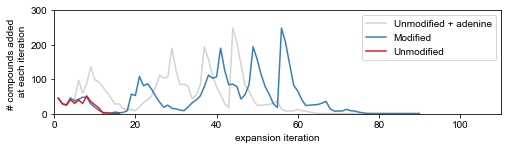

In [4]:
# now remove purine production 
metab_unmod = metabolism.copy()
ne_cpds,ne_rxns = metab_unmod.expand(seed_set,algorithm='trace')
rn_to_remove = [x for x in metab_unmod.network.rn.unique().tolist() if (('_gATP' in x) or ('_gGTP' in x))]
metab_unmod.network = metab_unmod.network[~metab_unmod.network.rn.isin(rn_to_remove)]
ne_cpds_np,ne_rxns_np = metab_unmod.expand(seed_set,algorithm='trace')
ne_cpds_np_ad,ne_rxns_np_ad = metab_unmod.expand(seed_set + ['C00147'],algorithm='trace')


cmap = sns.color_palette("Set1")
abun = pd.DataFrame(pd.Series(ne_cpds),columns=['iter']).reset_index().groupby('iter').count()
abun['compounds (cumulative)'] = abun['index'].cumsum()

abun_alt = pd.DataFrame(pd.Series(ne_cpds_np),columns=['iter']).reset_index().groupby('iter').count()
abun_alt['compounds (cumulative)'] = abun_alt['index'].cumsum()

abun_ad = pd.DataFrame(pd.Series(ne_cpds_np_ad),columns=['iter']).reset_index().groupby('iter').count()
abun_ad['compounds (cumulative)'] = abun_ad['index'].cumsum()

#sns.scatterplot(x='iter',y='compounds (cumulative)',data=abun)
plt.figure(figsize=(8,4/14*8))
sns.lineplot(x='iter',y='index',data=abun_ad.iloc[1:],color='lightgrey')
sns.lineplot(x='iter',y='index',data=abun.iloc[1:],color=cmap[1])
sns.lineplot(x='iter',y='index',data=abun_alt.iloc[1:],color=cmap[0])

plt.ylabel('# compounds added \n at each iteration')
plt.xlabel("expansion iteration")
plt.xlim([0,110])
plt.ylim([0,300])
plt.subplots_adjust(bottom=0.25)
plt.legend(['Unmodified + adenine','Modified','Unmodified'])

In [7]:
abun

,index,compounds (cumulative)
iter,,
0,89,89
1,45,134
2,29,163
3,26,189
4,46,235
...,...,...
86,1,4114
87,1,4115
88,1,4116
